In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc
import pymc3 as pm
import arviz as az
from numba import njit
from jupyterthemes import jtplot ; jtplot.style()

#### During our study with the Simon task, we noticed that several participants showed an increase in estimated drift rate when faced with conflicting or incongruent visual stimuli. Drift rate is a  parameter which aims to measure the rate of evidence accumulation in a fast two choice decision task, so it seemed odd to us that this should increase, rather than decrease in conflict/incongruent trials. 



#### Ulrich et al (2015) states that these seemingly contradictory results stem from the SDE that makes up the drift diffusion model (DDM). In the original DDM, an increase in drift rate leads to a decrease in both mean reaction time and standard deviation of the resulting reaction time distribution. In the Simon task however, the reaction time distribution for incongruent trials shows an increase in mean reaction time, but a decrase in standard deviation. 
#### The authors suggest that this is may be due to the fact that there are two drift processes happening simultaenously: one automatic drift process, which represents the leak of task-irrelevant information into the decision making process, and one controlled one, which accumulates task-relevant stimuli at a fixed rate. The automatic drift process either adds to the controlled drift process in non-conflict trials, or works against the controlled drift process in conflict trials . Furthermore, the automatic drift process decays over time. This design accounts for reaction time distributions in which conflict conditions lead to a decrease in reaction time.






#### These initial simulations were carried out in order to test whether or not our data followed the same pattern as what the authors describe in the paper above. Here, I also used PYMC's approximate bayesian computation (ABC) sequential Monte Carlo sampler to try and recover initial values. 

#### Due to the small number of reaction time data per participant, we used a hierarchical model to more accurately estimate model paramaters. Given the complexity of the DDM, it would be incredibly computationally expensive to use ABC (via e.g. pyABC) on a hierarchical version of the DDM, so we ultimately weren't able to use these simulator functions in the analysis of our data. Instead, we used the HDDM package in our final analyses.

In [3]:
def reaction_time(a, tau, sigma, mu_c, A, b, t, tmax = 2000, dt = 1) :
    '''
    generate a single reaction time stat in milliseconds: 
    a = shape of the automatic drift process
    tau = decay of the automatic drift process
    sigma = standard deviation of gaussian noise
    mu_c = controlled drift process rate
    b = boundary that the drift process must reach before a response can be executed
    A = amplitude of the automatic drift process. A > 0 on nonconflict trials. A < 0 on conflict trials.
    t = time taken for elements of the decision process outside of the drift diffusion mechanism (e.g. motor execution)
    '''
    c = 0
    time = np.arange(dt, tmax + 1, 1)
    mu = A * np.exp(-time / tau) * ((np.exp(1) * time)/((a-1) * tau))**(a-1) * (((a-1)/time) - (1/tau)) + mu_c
    dX = mu*dt + sigma * np.sqrt(dt) * np.random.randn(len(time))

    #b_int = int(b) #uncomment to estimate variable starting point
    #starting_pt_weights = [beta_pdf(i, 3, lim = (-b_int, b_int)) for i in range(-b_int, b_int)]
    #dX[0] = random.choices(range(-b_int, b_int), weights = starting_pt_weights)[0]

    X = np.cumsum(dX) 
    val = np.argwhere(np.abs(X) >= b)
    if val.size < 1 : 
        val = tmax + 300
    elif X[val[0][0]] >= b : 
        val = val[0][0]*dt + t #double slice to get the number instead of an array
    else : 
        val = (val[0][0] * dt + t) * -1
    return val

def beta_pdf(x, b, shape, lim = (-80, 80)) : #changed lin from tuple to list
    """beta probability density function: for a given value of x between [-b. b] return p dens"""
    val =  ((x - lim[0])*(lim[1]-x))**(shape-1) / (sc.beta(shape, shape) * (b+b)**(2*shape - 1))
    return val

In [10]:
@njit
def rt_sim(a, tau, sigma, mu_c, A, b, t, steps = 200, t_max = 2000) : 
    '''simulate n = steps rt trials '''
    rt = [] 
    for i in range(steps) : 
        rt.append(reaction_time(a, tau, sigma, mu_c, A, b, t, tmax = t_max)) 
    return np.sort(rt)

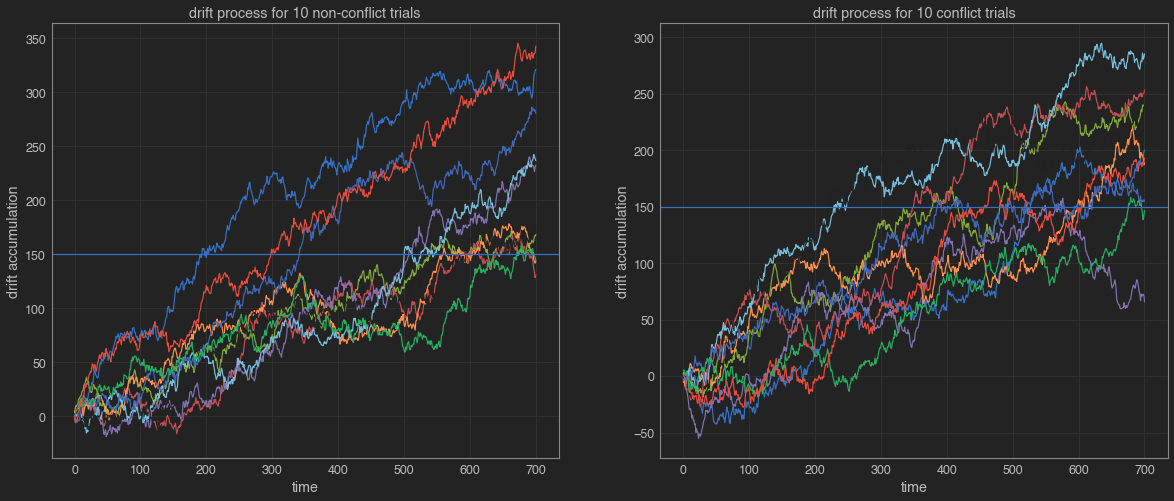

In [5]:
def drift_visualizer(a, tau, sigma, mu_c, A, tmax = 2000, dt = 1) :
    '''visualize drift accumulation process'''
    c = 0
    time = np.arange(dt, tmax + 1, 1)
    mu = A * np.exp(-time / tau) * ((np.exp(1) * time)/((a-1) * tau))**(a-1) * (((a-1)/time) - (1/tau)) + mu_c
    dX = mu*dt + sigma * np.sqrt(dt) * np.random.randn(len(time))

    X = np.cumsum(dX) 
    return X

a = 2 ; tau = 35 ; sigma = 3 ; mu_c = .3 ; A = 20 ; b = 150; n = 10 ; time_vec = np.linspace(0, 700, 701)
_, ax = plt.subplots(1, 2, figsize = (20, 8)) 
for i in range(n) :
    'n non-conflict trials'
    ax[0].plot(time_vec, drift_visualizer(a, tau, sigma, mu_c, A, tmax = 701))
ax[0].set_title('drift process for 10 non-conflict trials')
ax[0].set_xlabel('time')
ax[0].set_ylabel('drift accumulation')
ax[0].axhline(b) # line indicating boundary
for i in range(n) : 
    'n conflict trials'
    ax[1].plot(time_vec, drift_visualizer(a, tau, sigma, mu_c, -A, tmax = 701))
ax[1].set_title('drift process for 10 conflict trials')
ax[1].set_xlabel('time')
ax[1].set_ylabel('drift accumulation')
ax[1].axhline(b)

array([-367,  142,  149,  151,  151,  153,  154,  154,  154,  157,  157,
        157,  158,  159,  160,  161,  163,  163,  163,  165,  166,  166,
        166,  168,  170,  170,  170,  172,  172,  173,  175,  178,  179,
        181,  182,  183,  188,  191,  191,  194,  195,  196,  200,  201,
        202,  203,  203,  204,  204,  208,  208,  211,  212,  215,  217,
        219,  219,  219,  220,  221,  224,  226,  235,  235,  235,  236,
        238,  244,  246,  247,  247,  248,  249,  249,  250,  251,  251,
        252,  253,  256,  257,  257,  259,  261,  263,  266,  267,  269,
        271,  273,  273,  276,  277,  278,  282,  283,  284,  285,  288,
        291,  293,  294,  297,  299,  301,  301,  302,  304,  305,  305,
        307,  311,  312,  312,  315,  317,  318,  318,  319,  320,  320,
        323,  324,  325,  328,  330,  331,  333,  336,  337,  338,  339,
        345,  348,  348,  350,  352,  353,  353,  353,  356,  358,  363,
        366,  366,  369,  372,  375,  376,  377,  3

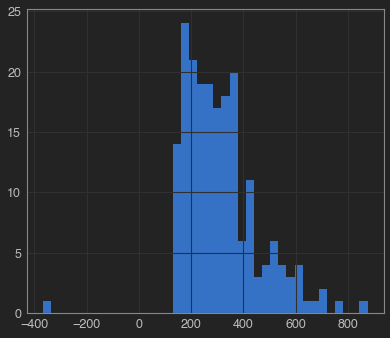

In [8]:
simu = rt_sim(2, 35, 4, .4, 20, 80, 120)
plt.hist(simu, bins = 40)
simu

In [52]:
like_free = pm.Model()
with like_free : 
    '''note the insanely tight priors...'''
    alpha = pm.Normal('a', mu = 2, sd = 1, testval = 2)
    tau = pm.Normal('tau', mu = 35, sd = 15, testval = 35)
    sigma = pm.Normal('sigma', mu = 4, sd = 2, testval = 4)
    A = pm.Normal('A', mu = 20, sd = 5)
    mu_c = pm.Normal('mu_c', mu = 0.3, sd = .1)
    b = pm.Normal('b', mu = 80, sd = 20)
    t = pm.Normal('t', mu = 120, sd = 20)
    like = pm.Simulator(
        'like', rt_sim, observed = np.asarray(simu)) 
    trace = pm.sample_smc(kernel = 'ABC', epsilon = .3)

Sample initial stage: ...
/Users/albertwakhloo/opt/anaconda3/envs/pymc36/lib/python3.6/site-packages/pymc3/smc/smc.py:120: UserWarning: Warning: SMC-ABC methods are experimental step methods and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)


KeyboardInterrupt: 

In [ ]:
def posterior_predictive(trace, i) :
    '''push trace samples thru equations'''
    pred = []
    pred.append(reaction_time(trace['a'][i], trace['tau'][i], trace['sigma'][i], trace['mu_c'][i], \
                              trace['A'][i], trace['b'][i])) 
    return pred